<a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/Multilinear_regression_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skp
import sklearn.linear_model as skl
import sklearn.metrics as skm
import sklearn.pipeline as skpp

## Getting the data

The file `https://github.com/paduapires/aapg_ice/raw/main/well_logs.xlsx` contains a dataset composed of well log data for 2 wells, with columns for:
- Well number: **well**
- Depth (m): **z**
- Gamma ray ($^\circ$API): **gr**
- Density ($g/cm^3$): **rho**
- Neutron porosity (.dec): **nphi**
- Compressional slowness ($\mu s/ft$): **dt_p**
- Shear slowness ($\mu s/ft$): **dt_s**
- Facies: **facies**

A planned future well will not measure **dt_s**. Our task is to develop a model that estimates **dt_s** (our **target**) from other available data (**features**). 

Since the task is **predicting** (or **inferring**) a **continuous** value (and not a **categorical** one), this is a **regression** task.

Since our models will use available measurements of the target value in order to learn how to map input features to the desired target outputs, this a **supervised** experiment.

In [2]:
# Construct the raw file URL for the Excel file on GitHub
excel_url = 'https://github.com/paduapires/aapg_ice/raw/main/well_logs.xlsx'

# Use pandas to read the Excel file directly from the raw URL
df = pd.read_excel(io=excel_url, engine='openpyxl')
display(df.sample(10))

,well,z,gr,rho,nphi,dt_p,dt_s,facies
19501,well_1,2641.854118,92.788757,2.301413,27.978673,118.276001,273.872319,MARL
28211,well_1,3969.258118,98.397324,2.593214,7.596422,63.184444,125.940376,SANDSTONE
22033,well_1,3027.730918,104.768318,2.268147,31.527564,115.110544,275.006965,SHALE
27069,well_1,3795.217318,185.764542,2.475681,25.360006,93.414749,172.826516,SHALE
18606,well_1,2505.456118,79.046860,2.261777,27.876343,111.293576,267.136893,MARL
19979,well_1,2714.701318,74.506050,2.359736,24.876842,110.242103,273.208457,MARL
4,well_0,1895.551372,17.350235,NaN,NaN,252.129702,NaN,NaN
29065,well_1,4099.407718,108.426712,2.421079,12.121577,72.606521,129.888507,SANDSTONE
23600,well_1,3266.541718,150.156708,2.378430,28.317453,102.033305,217.347010,SHALE
22174,well_1,3049.219318,121.907593,2.291830,33.263431,111.233035,246.385624,SHALE


In [3]:
# eliminating lines with incomplete data
df = df.dropna() # YOUR CODE HERE to drop lines with NaN
df.sample(10)

,well,z,gr,rho,nphi,dt_p,dt_s,facies
9102,well_0,3282.086572,96.878754,2.252867,39.552087,113.921281,276.412449,SANDSTONE
8993,well_0,3265.474972,95.689026,2.201104,47.487928,114.092714,294.403888,SHALE
15700,well_0,4287.621772,91.540802,2.435510,32.815463,89.228877,168.551366,SHALE
28413,well_1,4000.042918,143.753906,2.483658,23.312133,87.987636,160.507388,SHALE
10657,well_0,3519.068572,79.436020,2.383960,20.595650,107.084395,206.224634,SHALE
29933,well_1,4231.690918,116.545433,2.411238,17.001151,73.699177,139.132615,SANDSTONE
25161,well_1,3504.438118,69.775742,2.481118,8.931492,62.394533,102.793360,SANDSTONE
6689,well_0,2914.345372,65.891541,2.147372,33.406081,119.205772,303.904799,SANDSTONE
20472,well_1,2789.834518,94.623482,2.248413,24.575575,106.884161,254.164672,SANDSTONE
21507,well_1,2947.568518,82.500443,2.267904,27.992000,109.069285,233.397200,SHALE


### Exploratory data analysis

Columns `well` and `facies` contain **categorical** data. Counting the ocurrence of each is an easy way to start the analysis.

In [4]:
df[['well','facies']].value_counts()

well    facies     
well_1  SANDSTONE      6066
        SHALE          6052
well_0  SANDSTONE      5500
        SHALE          4986
well_1  MARL           1680
well_0  MARL           1170
        CALCARENITE    1091
        CALCILUTITE     615
well_1  SILTSTONE       453
well_0  SILTSTONE       134
        ANHYDRITE       114
well_1  CALCILUTITE      93
well_0  DOLOMITE         69
well_1  SAND              7
Name: count, dtype: int64

The `'SAND'` facies has very few examples. Let's merge them into the `'SANDSTONE'` facies:

In [5]:
sand_mask = df['facies']=='SAND'  # YOUR CODE HERE to make a logical mask that selects only SAND
df.loc[sand_mask,'facies'] = 'SANDSTONE' # changing values in a DataFrame can be finicky... 
df['facies'].value_counts()

facies
SANDSTONE      11573
SHALE          11038
MARL            2850
CALCARENITE     1091
CALCILUTITE      708
SILTSTONE        587
ANHYDRITE        114
DOLOMITE          69
Name: count, dtype: int64

In [6]:
# creating a colormap for each facies
cmap = {'ANHYDRITE':'magenta', 'SANDSTONE':'xkcd:goldenrod', 'CALCARENITE':'cyan',
        'CALCILUTITE':'xkcd:dark blue', 'DOLOMITE':'purple', 'SHALE':'green',
        'MARL':'xkcd:greenish blue', 'SILTSTONE':'xkcd:reddish orange'}
facies_list = list(df['facies'].unique())
print(facies_list)

['SANDSTONE', 'MARL', 'SHALE', 'CALCILUTITE', 'SILTSTONE', 'CALCARENITE', 'ANHYDRITE', 'DOLOMITE']


The following function will be usefull for plotting the model results

In [8]:
def per_facies_scatter(y_hat,y,facies,xlabel=None,ylabel=None,
                       suptitle='',marker='.',linestyle='',cmap=cmap,fig_kwargs=None,plt_kwargs=None):
    '''Plots y_hat versus y for each facies'''
    n_groups = len(facies_list)  # uses global facies_list
    labels = ['All'] + facies_list # uses global facies_list
    
    y_hat = np.asarray(y_hat)
    y = np.asarray(y)
    facies = np.asarray(facies)

    if fig_kwargs is None: fig_kwargs = dict()
    if plt_kwargs is None: plt_kwargs = dict()
    
    nlin = int(np.floor(np.sqrt(n_groups+1)))
    ncol = int(np.ceil(n_groups/nlin))
    fig,axs = plt.subplots(nlin,ncol,sharex='all',sharey='all',
                           gridspec_kw={'wspace':0,'hspace':0}, **fig_kwargs)
    mM = min([y_hat.min(),y.min()]) , max([y_hat.max(),y.max()])
    
    for i,(ax,label) in enumerate(zip(axs.flat,labels)):
        ax.plot(mM,mM,'k--'), ax.grid()
        if i == 0: # All points
            mask = np.full(y_hat.shape,True)
        else:
            mask = facies==label
        if not mask.any(): #Se nao tem a classe, pula
            continue
        y_hat_mask,y_mask = y_hat[mask],y[mask]
        MSE = ((y_hat_mask-y_mask)**2).mean()
        RMSE = np.sqrt(MSE)
        R2 = 1 - MSE/y.var()
        color = cmap.get(label,'C0')
        ax.plot(y_hat_mask,y_mask,marker=marker,linestyle=linestyle,color=color,
                label=f'{label}\n{RMSE=:.2f}\n{R2=:.3f}',**plt_kwargs)
        ax.legend(fontsize=8)
    if xlabel:
        axs[-1     ,ncol//2].set_xlabel(xlabel)
    if ylabel:
        axs[nlin//2,0      ].set_ylabel(ylabel)
    fig.suptitle(suptitle)
    plt.tight_layout()
    return fig,axs


The other columns contain continuous data. Let's visualize how each *feature* correlates to the *target* **dt_s**:

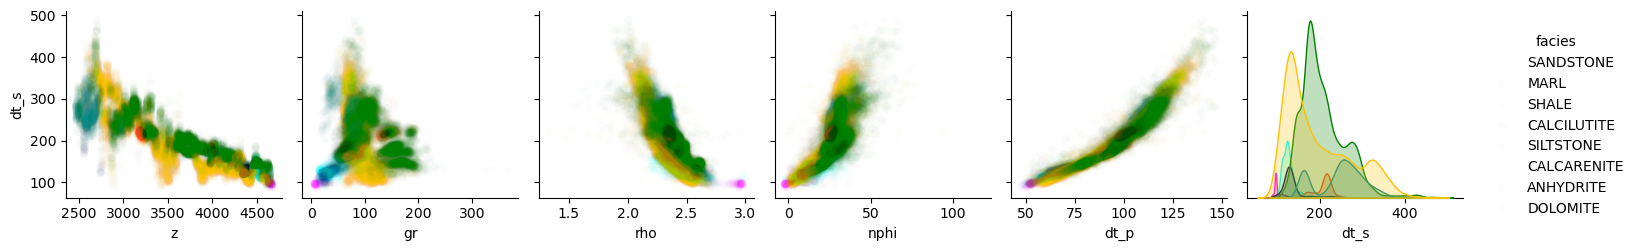

In [7]:
sns.pairplot(data=df,x_vars=df.columns[1:-1],y_vars=['dt_s'], hue='facies',
             plot_kws={'alpha':0.01,'edgecolor':'none'},palette=cmap)
plt.show() # lots of points, takes a few seconds....

### Feature selection and Dataset splitting

As domain experts, it is our responsibility to choose the best features as inputs to the regression models, being mindfull not only that the selected features are truly informative for estimating the target, but also that these choices will impact the future applicability of the model, since all input features must be available in future wells for the inference to be possible.

We will use the more numerous `well_0` as a **training dataset**, to  **optimize** the **loss function** and obtain the optimum **model parameters** for several models.

The **validation dataset** `well_1` will be used to **select the best model** for future use.

In [15]:
features = [ 'rho' , 'nphi' , 'dt_p' ] # YOUR CODE HERE. Should we use 'z'? 'What about 'nphi'?
target = 'dt_s'

mask_train = df['well']=='well_0'  # logical maks
mask_validation = ~mask_train

df_train = df[mask_train]
df_validation = df[mask_validation]

X_train = df_train[features]
y_train = df_train[target]

X_validation = df_validation[features]
y_validation = df_validation[target]

# Multilinear Regression

One of the simplest and most flexible models for predicting continuous outcomes if the multilinear regression model:

$$y_i \approx \hat{y}_i = w_0 + w_1 x_{i1} + w_2 x_{i2} + \cdots + w_M x_{iM} = \vec{x}_i\cdot \vec{w}
$$

Where $y_i$ is the *ground truth* for the *target* variable of the $i$-th example, which we would like to predict based on its $M$ known *features* $x_{ij}$ ($j=1,2,\dots,M$). The *prediction* $\hat{y}_i$ is simply a linear combination of the *features*.

Each example is represented by its (augmented) *feature vector* $\vec{x}_i$, where we define $x_{i0}=1$ for all examples, so the *inference* step can be written as a single dot product between the *feature vector* ($\vec{x}_i$) and the *weights vector* ($\vec{w}$).

The model *parameters* $w_j$ are known as its *weights* ($w_j$, for $j\geq1$) and *bias* ($w_0$). 

It is common to organize the entire dataset of $N$ examples in a matrix $X$  ($N\times M+1$) like so:

$$X = \begin{bmatrix} \vec{x}_1^T \\ \vec{x}_2^T \\ \vdots \\ \vec{x}_N^T
\end{bmatrix} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1M} \\
1 & x_{21} & x_{22} & \cdots & x_{2M} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{N1} & x_{N2} & \cdots & x_{NM} \\
\end{bmatrix}
$$

where each line represents a different example, and each column is a different feature, including the constant $1$ feature. This way, the multilinear model can be written as a single matrix equation:

$$
X\vec{w} = \vec{\hat{y}} \qquad ; \qquad \vec{\hat{y}} \approx \vec{y}
$$

It is important to choose an **objective function** (also called a **loss function**) that expresses mathematically how good the model is. The most common objetive function is the **Sum of Squared Errors**:

$$
SSE = \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 = \lVert \vec{\hat y} - \vec{y} \rVert^2 = \lVert X\vec{w} - \vec{y} \rVert^2
$$

The problem of obtaining the best parameters can then be written as:

$$
\underbrace{\text{argmin}}_{\vec{w}} \quad  \lVert X\vec{w} - \vec{y} \rVert^2
$$

This particular problem has a closed form analytical solution given by solving the so-called normal equations:

$$\begin{align}
X^TX\vec{w} = &X^T\vec{y}\\
\vec{w} = & \left(X^TX\right)^{-1}X^T\vec{y}
\end{align}
$$

### Degree 1 model - Numpy

There are several methods for solving the normal equations. One of the most widely used packages for these kinds of linear algebra is `numpy.linalg`, which implements the function `np.linalg.lstsq`: 

Optimum bias and weights: w1 = array([-15.64247265, -42.44935114,  -1.13052335,   3.69968597])


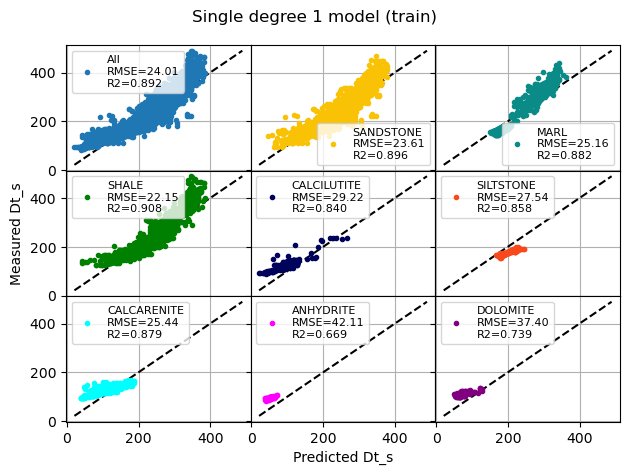

In [16]:
X1_train = np.column_stack([np.ones(X_train.shape[0]), X_train]) # Adding a column of the constant 1 feature

w1,*_ = np.linalg.lstsq( X1_train, y_train) # YOUR CODE HERE. Solving the least squares problem, TRAINING the model
print(f'Optimum bias and weights: {w1 = }')

y_hat1_train = X1_train @ w1 # YOUR CODE HERE. Using the model, running INFERENCE on the TRAINING SET


xlabel = 'Predicted Dt_s'
ylabel = 'Measured Dt_s'
per_facies_scatter(y_hat1_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (train)');

### Validation dataset

However, what are interested in how well the model performs when presented with data it has never seen before:

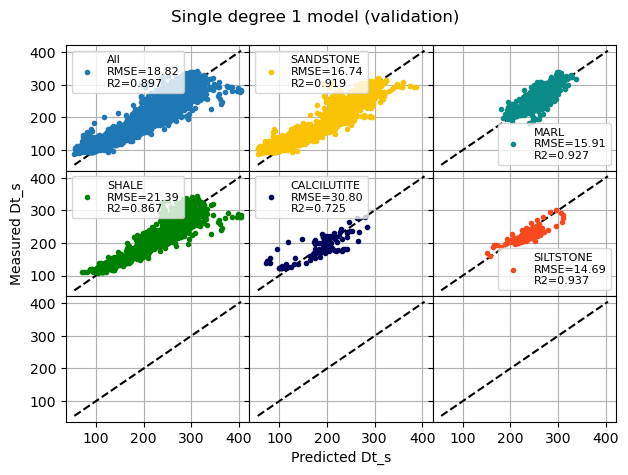

In [17]:
X1_validation = np.column_stack([np.ones(X_validation.shape[0]), X_validation]) # Adding a column of the constant 1 feature
y_hat1_validation = X1_validation @ w1 # YOUR CODE HERE. Using the model, running INFERENCE on the VALIDATION DATASET

per_facies_scatter(y_hat1_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (validation)');

### Degree 1 model - Scikit-learn

For ML tasks, the `sklearn` module implements many of the most widely used models. Linear Regression is implements in `skl.LinearRegression`, which implements the methods `.fit` and `.predict`.

The model parameters are stored in the attributes `.intercept_` and `.coef_`. The presence of these attributes in sklearn estimators indicates if the estimator has already been trained. By convention, variables which end with an underscore (`_`) are suposed to only be used internally, so be careful with those. 

In [18]:
model1 = skl.LinearRegression(fit_intercept=True) # instantiating the model
model1.fit(X_train, y_train) # TRAINING the model. No need to add the 1 column because fit_intercept=True handles that for us

# Verifying the parameters are the same ones we found earlier
print(f'''numpy: 
 {w1 = }
 
sklearn:
 {model1.intercept_ = }
 {model1.coef_ = }''')

numpy: 
 w1 = array([-15.64247265, -42.44935114,  -1.13052335,   3.69968597])

sklearn:
 model1.intercept_ = np.float64(-15.642472652296448)
 model1.coef_ = array([-42.44935114,  -1.13052335,   3.69968597])


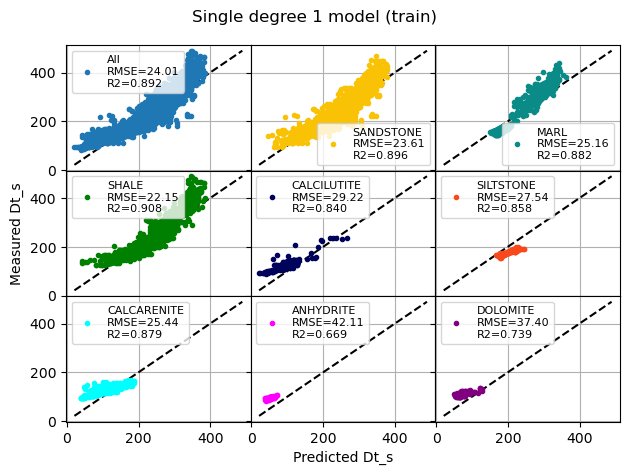

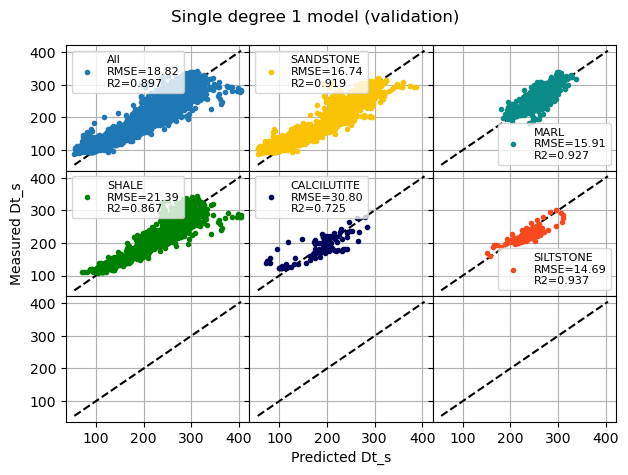

In [19]:
y_hat1_train = model1.predict(X_train) # Running INFERENCE on the TRAINING SET
y_hat1_validation = model1.predict(X_validation) # YOUR CODE HERE to run inference on the VALIDATION SET

per_facies_scatter(y_hat1_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (train)');
per_facies_scatter(y_hat1_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (validation)');

## Underfitting and Feature engineering

It seems the model consistently underestimates the target variable on some regions of the data range, while overestimating it around others, even for data it was trained on. This behaviour is called **underfitting**, and is typical models that are insuficiently flexible, unable to capture more complex dependencies between the input features and the target variable.

It seems like our target variable **dt_s** might have a nonlinear dependence on the input variables. One way to account for that is by creating new features from nonlinear combination of the original features. These new features can be handcrafted by using specialist domain knowledge, or simply generated from a stock of premade recipes.

A common way of achieving this is by creating **polynomial features** of up to degree N (a **hyperparameter**, which is chosen by the scientist, not optimized by the loss function). This functionality is available via `skp.PolynomialFeatures`, which implements the `.fit` and `.transform` methods.

In [20]:
poly = skp.PolynomialFeatures(degree=3) # change the maximum degree to see what happens
poly.fit(X_train)  # there are NO learned parameters here. The fit method only binds the names of the features to apply the transformation
X_poly = poly.transform(X_train) # .transform applies the transformation

pd.DataFrame(X_poly,columns=poly.get_feature_names_out()).sample(3)

,1,rho,nphi,dt_p,rho^2,rho nphi,rho dt_p,nphi^2,nphi dt_p,dt_p^2,rho^3,rho^2 nphi,rho^2 dt_p,rho nphi^2,rho nphi dt_p,rho dt_p^2,nphi^3,nphi^2 dt_p,nphi dt_p^2,dt_p^3
12720,1.0,2.526188,13.925702,62.533922,6.381627,35.178945,157.972460,193.925177,870.828771,3910.491458,16.121191,88.868637,399.068171,489.891502,2199.877404,9878.637554,2700.544228,12126.901972,54456.338808,2.445384e+05
3048,1.0,2.260802,41.928228,112.380579,5.111227,94.791436,254.070274,1757.976327,4711.918585,12629.394610,11.555474,214.304697,574.402663,3974.436950,10652.716444,28552.564569,73708.832757,197562.398074,529528.140288,1.419299e+06
6592,1.0,2.279433,30.998839,96.698372,5.195817,70.659791,220.417508,960.927996,2997.537218,9350.575079,11.843519,161.064295,502.427051,2190.371464,6832.686749,21314.014070,29787.651880,92920.172490,289856.967921,9.041854e+05


### Pipeline

Since all data that goes into our model will have to go through the same preprocessing and feature engineering steps before being passed throught to the linear regressor, it is convenient to store all these steps into a single `skpp.Pipeline` object, which automates this chain of compositions. These can easily be created with the `skpp.make_pipeline` convenience function.


In [31]:
pipe2 = skpp.make_pipeline(
    skp.PolynomialFeatures(degree=2, include_bias=False), # no need to create the constant column, since the LinearRegression handles that
    skl.LinearRegression()            
)
pipe2

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

`skpp.Pipeline` objects also have the `.fit`, `.transform` and `.predict` methods, which are run sequentially on each of its steps. 

In [32]:
pipe2.fit(X_train, y_train)  # YOUR CODE HERE. Training the model on the TRAINING SET
pipe2

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

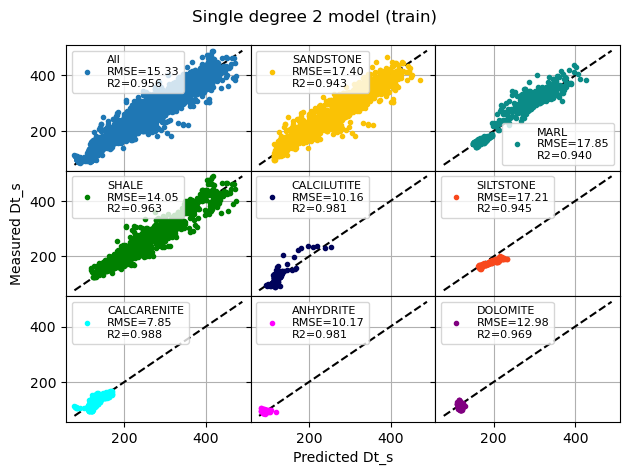

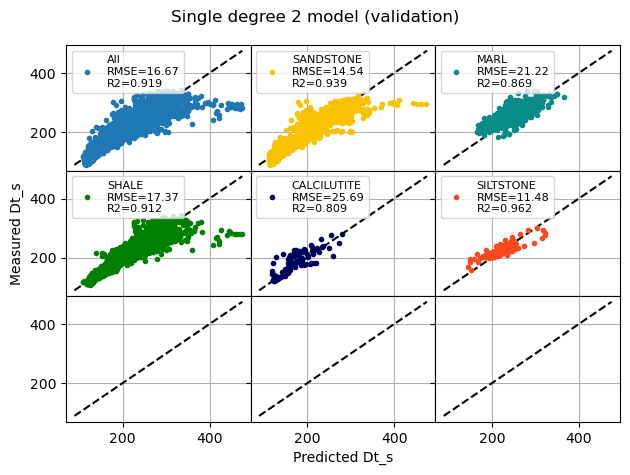

In [33]:
y_hat2_train = pipe2.predict(X_train) # YOUR CODE HERE to apply the pipeline to the TRAINING SET
y_hat2_validation = pipe2.predict(X_validation)  # YOUR CODE HERE to apply the pipeline to the VALIDATION SET

deg = pipe2['polynomialfeatures'].degree # each step of the pipeline can be accessed via its name, if needed

per_facies_scatter(y_hat2_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle=f'Single degree {deg} model (train)');
per_facies_scatter(y_hat2_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle=f'Single degree {deg} model (validation)');

## Specialized models for each facies

It seems like some facies have much better performance than others. Since some facies are underrepresented in the dataset, the single model we created is not incentivized to accurately predict **dt_s** for these rare facies. It is often worth it to create specialized models for each facies (or group of facies).

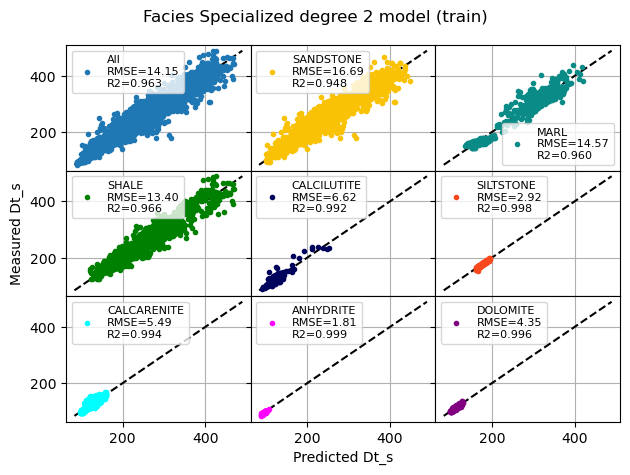

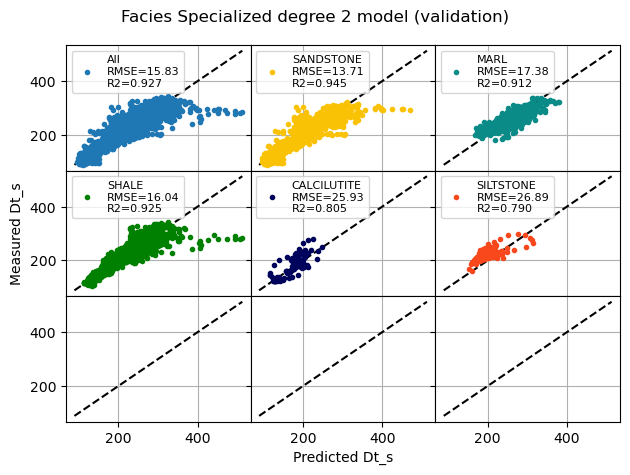

In [34]:
pipes3 = dict() # initializing an empty dict

# Training data set
y_hat3_train = 0*y_train # initializing a zeroed vector of predictions
for fac in facies_list:
    fac_pipe = skpp.make_pipeline(skp.PolynomialFeatures(degree=2,include_bias=False), 
                               skl.LinearRegression()
                                     )
    mask_fac_train = df_train['facies'] == fac # logical mask
    fac_pipe.fit(X_train[mask_fac_train],y_train[mask_fac_train]) # training only on the relevant facies
    pipes3[fac] = fac_pipe # storing the pipeline for later use
    
    y_hat3_train[mask_fac_train] = pipes3[fac].predict(X_train[mask_fac_train])

# Validation data set
y_hat3_validation = 0*y_validation # initializing a zeroed vector of predictions
for fac in facies_list:
    mask_fac_validation = df_validation['facies'] == fac # logical mask
    if not mask_fac_validation.any(): 
       continue # if there are no data points of the given facies, no need to run the model
    y_hat3_validation[mask_fac_validation] = pipes3[fac].predict(X_validation[mask_fac_validation]) # YOUR CODE HERE

per_facies_scatter(y_hat3_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, 
                   suptitle=f'Facies Specialized degree {fac_pipe['polynomialfeatures'].degree} model (train)');
per_facies_scatter(y_hat3_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, 
                   suptitle=f'Facies Specialized degree {fac_pipe['polynomialfeatures'].degree} model (validation)');

### Overfitting

It might be reasonable to assume that a more specialized model, or one with more adjustable parameters, will be able to fit the data more closely. While that is true of the **training set**, it might not be so for novel data (represented here by the **validation set**). If it is the case that the model performance is good on the training data, but is significantly worse for novel data, we say that the model does **not generalize** well, it **overfits** the training data.

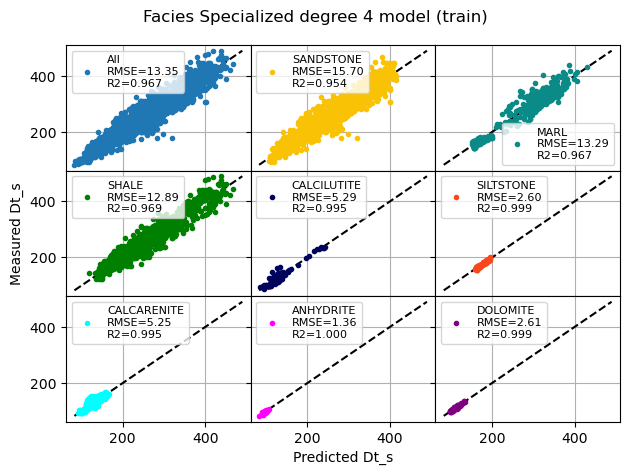

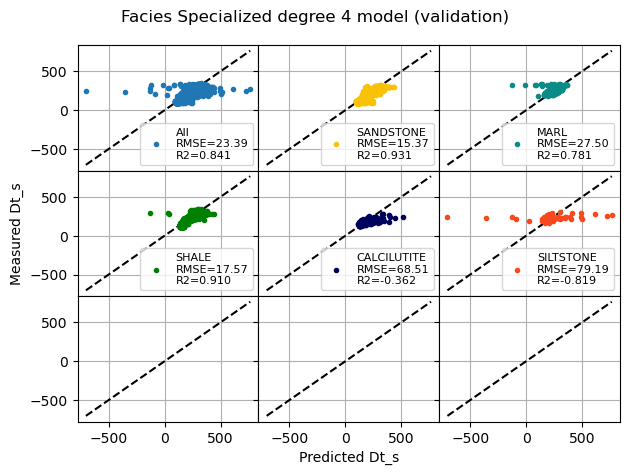

In [35]:
pipes4 = dict() # initializing an empty dict of models

# Training data set
y_hat4_train = 0*y_train # initializing a zeroed vector of predictions
for fac in facies_list:
    fac_pipe = skpp.make_pipeline(skp.PolynomialFeatures(degree=4,include_bias=False), # Try several degrees
                               skl.LinearRegression()
                                     )
    mask_fac_train = df_train['facies'] == fac # logical mask
    fac_pipe.fit(X_train[mask_fac_train],y_train[mask_fac_train]) # training only on the relevant facies
    pipes4[fac] = fac_pipe # storing the pipeline for later use
    
    y_hat4_train[mask_fac_train] = pipes4[fac].predict(X_train[mask_fac_train])

# Validation data set
y_hat4_validation = 0*y_validation # initializing a zeroed vector of predictions
for fac in facies_list:
    mask_fac_validation = df_validation['facies'] == fac # logical mask
    if not mask_fac_validation.any(): 
       continue # if there are no data points of the given facies, no need to run the model
    y_hat4_validation[mask_fac_validation] = pipes4[fac].predict(X_validation[mask_fac_validation]) # YOUR CODE HERE

per_facies_scatter(y_hat4_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, 
                   suptitle=f'Facies Specialized degree {fac_pipe['polynomialfeatures'].degree} model (train)');
per_facies_scatter(y_hat4_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, 
                   suptitle=f'Facies Specialized degree {fac_pipe['polynomialfeatures'].degree} model (validation)');

There are many metrics we can use to judge model model performance. Many of them are implemented in `sklearn.metrics` (and there are many more which are not).

The best performing model (along with all preprocessing steps) as measured by the performance on the **validation dataset** should be stored for later use. 

The best practice is to also do a unbiased estimation of its performance on a proxy of future data, that is, neither the training set (which is biased since it was used for parameter optimization), nor the validation set (which is biased since it was used for hyperparameter tuning). This extra **holdout data** is usually called the **test set**, though some sources reverse the use of "validation" and "test", and some others use them interchangeably.

In [36]:
print('Mean Squared Error (train)      :',skm.mean_squared_error(y_train,y_hat4_train))
print('Mean Squared Error (validation) :',skm.mean_squared_error(y_validation,y_hat4_validation ))
print()
print('Root Mean Squared Error (train)      :',np.sqrt(skm.mean_squared_error(y_train,y_hat4_train)))
print('Root Mean Squared Error (validation) :',np.sqrt(skm.mean_squared_error(y_validation,y_hat4_validation )))
print()
print('Mean Absolute Error (train)      :',skm.mean_absolute_error(y_train,y_hat4_train))
print('Mean Absolute Error (validation) :',skm.mean_absolute_error(y_validation,y_hat4_validation ))
print()
print('R2 (train)      :',skm.r2_score(y_train,y_hat4_train))
print('R2 (validation) :',skm.r2_score(y_validation,y_hat4_validation ))
print()
print('Max Absolute Error (train)      :', np.max(np.abs(y_train-y_hat4_train)))
print('Max Absolute Error (validation) :', np.max(np.abs(y_validation-y_hat4_validation)))


Mean Squared Error (train)      : 178.31471780451176
Mean Squared Error (validation) : 546.9336071944242

Root Mean Squared Error (train)      : 13.35345340368969
Root Mean Squared Error (validation) : 23.38661170829208

Mean Absolute Error (train)      : 8.846609984706818
Mean Absolute Error (validation) : 12.826901477126288

R2 (train)      : 0.9666677382117116
R2 (validation) : 0.8413091161999423

Max Absolute Error (train)      : 140.6262198844124
Max Absolute Error (validation) : 943.38861494623
